In [2]:
import findspark
findspark.init()

In [3]:
import pyspark
import random
#sc = pyspark.SparkContext(appName="Pi")

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession \
                .builder \
                .appName("als-implicit") \
                .config("spark.some.config.option", "some-value") \
                .getOrCreate()

In [8]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

# Load and parse the data
train = spark.read.text("4fold/4fold_0_train.tsv").rdd
trainParts = train.map(lambda row: row.value.split("\t"))
#column type must be integer
trainRatingsRDD = trainParts.map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]),
                                     rating=float(p[2])))#, timestamp=int(p[3])))
train = spark.createDataFrame(trainRatingsRDD)

In [9]:
valid = spark.read.text("4fold/4fold_0_val.tsv").rdd
validParts = valid.map(lambda row: row.value.split("\t"))
#column type must be integer
validRatingsRDD = validParts.map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]),
                                     rating=float(p[2])))#, timestamp=int(p[3])))
validation = spark.createDataFrame(validRatingsRDD)

test = spark.read.text("4fold/4fold_test.tsv").rdd
testParts = test.map(lambda row: row.value.split("\t"))
#column type must be integer
testRatingsRDD = testParts.map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]),
                                     rating=float(p[2])))#, timestamp=int(p[3])))
test = spark.createDataFrame(testRatingsRDD)

In [10]:
def print_mse(model, data, text):
    predictions = model.transform(data)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    print(text+" Root-mean-square error = " + str(rmse))
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(rank = 70, maxIter=10, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", implicitPrefs=True, alpha=1)
model = als.fit(train)

# Evaluate the model by computing the RMSE on the test data
print_mse(model, train, "train")
print_mse(model, validation, "valid")
print_mse(model, test, "test")

train Root-mean-square error = 0.978051245978662
valid Root-mean-square error = 0.9790378641484552
test Root-mean-square error = 0.9789048479500252


In [11]:
top50 = model.recommendForAllUsers(50)

In [13]:
from pyspark.sql.functions import *

In [15]:
top50.select(format_string('%d\t%s',top50.userId, top50.recommendations)).write.save("implicit_70_0.1_1_top50rec.out",format="text")

In [ ]:
def run(numIterations, alpha, lam, rank, train, validation, test):
    print("iter: {}, alpha:{}, lam: {}, rank: {}".format(numIterations, alpha, lam, rank))
    als = ALS(rank = rank, maxIter=numIterations, regParam=lam, userCol="userId", itemCol="movieId", ratingCol="rating",
                      coldStartStrategy="drop", implicitPrefs=True, alpha=alpha)
    model = als.fit(train)

    # Evaluate the model by computing the RMSE on the test data
    print_mse(model, train, "train")
    print_mse(model, validation, "valid")
    print_mse(model, test, "test")

for numIterations in [15]:
    for rank in [10, 75, 200]:
        for alpha in [0.01,0.1,1]:
            for lam in [0.01,0.1]:
                run(numIterations, alpha, lam, rank, train, validation, test)

안돼면 그거 머냐 rdd말고 다른쪽으로 해보자

In [18]:
result = dict()
with open('top50rec') as f:
    line = f.readline()
    while line:
        a = int(line[:7])
        b = eval(line[8:])
        result[a] = b
        line = f.readline()

In [19]:
len(result)

47018

In [20]:
trainDF = train.collect()
from collections import defaultdict
trainDict = defaultdict(list)
for row in trainDF:
    trainDict[row.userId].append(row.movieId)
removeDict = defaultdict(list)
for key, values in result.items():
    for value in values:
        if value[0] in trainDict[key]:
            removeDict[key].append(value)
for key, values in removeDict.items():
    for value in values:
        result[key].remove(value)

In [21]:
for key, value in result.items():
    print(len(value))
    break

50


In [22]:
testDF = test.collect()
testDict = defaultdict(list)
for row in testDF:
    testDict[row.userId].append(row.movieId)
precisions, recalls = [], []
for key, values in result.items():
    n_rel = len(testDict[key])
    n_rec_k = len(values)
    n_rel_and_rec_k = 0
    for value in values:
        if value[0] in testDict[key]:
            n_rel_and_rec_k += 1
    precisions.append( n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1 )
    recalls.append( n_rel_and_rec_k / n_rel if n_rel != 0 else 1 )


0.004055643924019291

In [29]:
import numpy as np

klist = list(range(1,51))
precisions_test = []
recalls_test = []
f1_test = []
for k in klist:
    topDict = dict()
    for key, value in result.items():
        if len(value) >= k:
            topDict[key]=value[:k]
        else:
            topDict[key]=value
    precisions, recalls = [], []
    for key, values in topDict.items():
        n_rel = len(testDict[key])
        if n_rel == 0:
            continue
        n_rec_k = len(values)
        n_rel_and_rec_k = 0
        for value in values:
            if value[0] in testDict[key]:
                n_rel_and_rec_k += 1
        precisions.append( n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1 )
        recalls.append( n_rel_and_rec_k / n_rel if n_rel != 0 else 1 )
    precision=np.sum(precisions)/len(precisions)
    recall=np.sum(recalls)/len(recalls)
    precisions_test.append(precision)
    recalls_test.append(recall)
    f1_test.append(2*(precision*recall)/(precision+recall))

In [26]:
validDF = validation.collect()
validDict = defaultdict(list)
for row in validDF:
    validDict[row.userId].append(row.movieId)
precisions, recalls = [], []
for key, values in result.items():
    n_rel = len(validDict[key])
    n_rec_k = len(values)
    n_rel_and_rec_k = 0
    for value in values:
        if value[0] in validDict[key]:
            n_rel_and_rec_k += 1
    precisions.append( n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1 )
    recalls.append( n_rel_and_rec_k / n_rel if n_rel != 0 else 1 )

In [30]:
precisions_val = []
recalls_val = []
f1_val = []
for k in klist:
    topDict = dict()
    for key, value in result.items():
        if len(value) >= k:
            topDict[key]=value[:k]
        else:
            topDict[key]=value
    precisions, recalls = [], []
    for key, values in topDict.items():
        n_rel = len(validDict[key])
        if n_rel == 0:
            continue
        n_rec_k = len(values)
        n_rel_and_rec_k = 0
        for value in values:
            if value[0] in validDict[key]:
                n_rel_and_rec_k += 1
        precisions.append( n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1 )
        recalls.append( n_rel_and_rec_k / n_rel if n_rel != 0 else 1 )
    precision=np.sum(precisions)/len(precisions)
    recall=np.sum(recalls)/len(recalls)
    precisions_val.append(precision) 
    recalls_val.append(recall) 
    f1_val.append(2*(precision*recall)/(precision+recall)) 
    #print("precision at k={}: ".format(k),precision)
    #print("recall at k={}: ".format(k),recall)
    #print("f1 score at k={}".format(k),2*(precision*recall)/(precision+recall))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc('figure', figsize=(16, 8), max_open_warning=False)

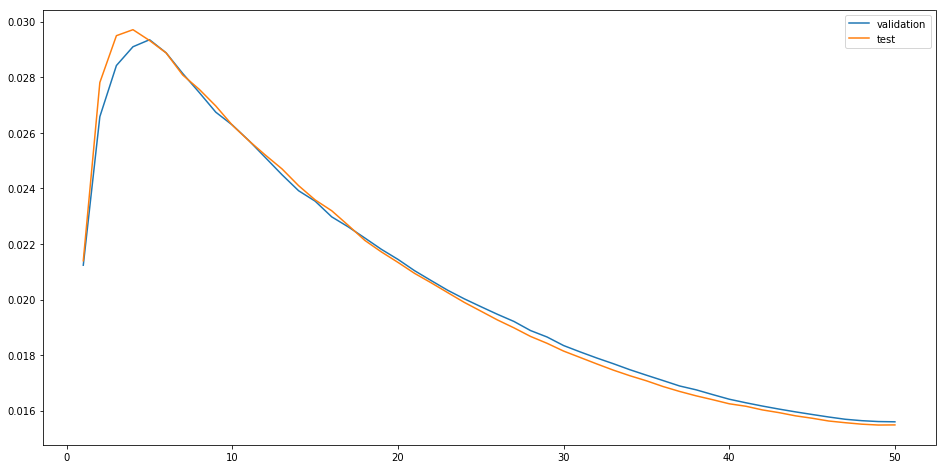

In [41]:
plt.plot(klist, f1_val, label="validation")
plt.plot(klist, f1_test, label="test")
plt.legend()
plt.show()

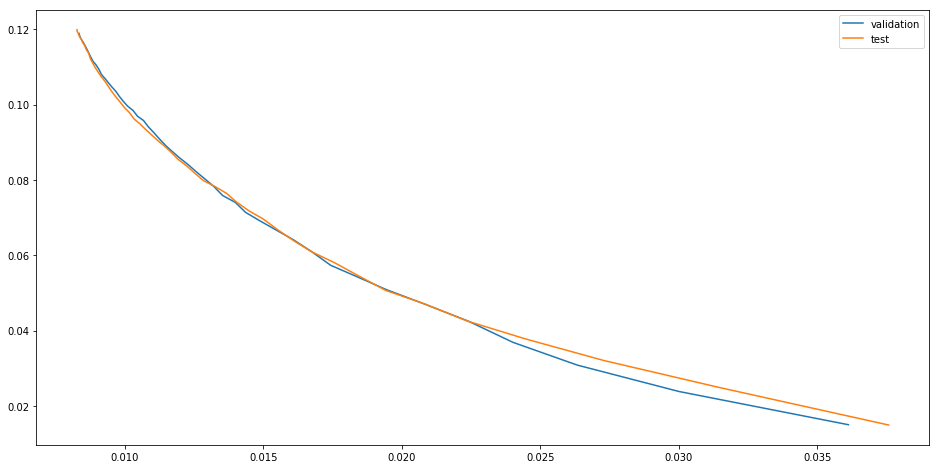

In [40]:
plt.plot(precisions_val, recalls_val, label="validation")
plt.plot(precisions_test, recalls_test, label="test")
plt.legend()
plt.show()